In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!git clone https://github.com/LinHuiqing/50.039-TheoryAndPracticeOfDeepLearning-SmallProject.git

Cloning into '50.039-TheoryAndPracticeOfDeepLearning-SmallProject'...
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
cd /content/gdrive/MyDrive/50.039-TheoryAndPracticeOfDeepLearning-SmallProject

/content/gdrive/MyDrive/50.039-TheoryAndPracticeOfDeepLearning-SmallProject


In [3]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# tqdm
from tqdm.notebook import tqdm

2.a. Creating a global Dataset object
Let us start this part by creating a general Dataset object, called Lung_Dataset.
It starts with of a constructor, which simply gathers the key parameters we listed in Part 1., into attributes of the object.
Second, a describe method is provided, which simply displays a few details regarding the dataset. Note that a describe function like this one is often considered good practice, as it provides any developer with details about the dataset, at a glance.
Third, an open_image method is provided, an will open the image defined by the combination of parameters defined in (group_val, class_val, index_val). For instance, if group_val is set to 'train', class val is set to 'normal' and index_val set to 3, the function will load the image in ./dataset_demo/train/normal/3.jpg. Note that the open_image method has a few asserts designed to cover for unexpected values for (group_val, class_val, index_val).
Finally, it contains a show_img method, which will open the image for the parameters in (group_val, class_val, index_val), and will display it on screen, using matplotlib.
Our full general Dataset object, Lung_Dataset, is shown below. Note that it inherits from the Dataset class from the torch.utils.data library.

In [4]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530,\
                                'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_noncovid': 8,\
                                'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_noncovid': 242}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid/',\
                              'val_normal': './dataset/val/normal/',\
                              'val_infected_covid': './dataset/val/infected/covid/',\
                              'val_infected_noncovid': './dataset/val/infected/non-covid/',\
                              'test_normal': './dataset/test/normal/',\
                              'test_infected_covid': './dataset/test/infected/covid/',\
                              'test_infected_noncovid': './dataset/test/infected/non-covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        

    def show_distribution(self):
        """
        Plotting function.
        Will plot the graphs showing the distribution of images among classes when called.
        """
        # Data to plot
        data = [list(self.dataset_numbers.values())[0:3], list(self.dataset_numbers.values())[3:6], list(self.dataset_numbers.values())[6:9]]
        labels = []
        for key, value in self.classes.items():
            labels.append("Class {}:\n{}".format(key, value))
        
        # Format plot area
        X = np.arange(len(labels))
        width = 0.15
        fig, ax = plt.subplots()
        rects1 = ax.bar(X - width, data[0], width , label = 'train')
        rects2 = ax.bar(X, data[1], width, label='validation')
        rects3 = ax.bar(X + width, data[2], width, label = 'test')
        fig.tight_layout()
        fig.set_size_inches(18.5, 10.5)

        # Add plot title, y-axis label, custom x-axis tick labels
        ax.set_ylabel('Number of images', fontsize = 17)
        ax.set_title('Number of images by dataset type and class', fontsize = 17)
        ax.set_xticks(X)
        ax.set_xticklabels(labels, Fontsize = 17)
        ax.legend(fontsize = 17)

        # Display plot
        plt.yticks(fontsize = 15)
        plt.show()

        # Save figure
        filename = 'Image_Distribution.png'
        fig.savefig(filename, dpi=100)
        print("Plot has been saved as {} in the submission folder.".format(filename))


    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

It can simply be called, and a generic description can be displayed.

This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5856 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 9 images.
 - val_infected_noncovid, in folder ./dataset/val/infected/non-covid/: 8 images.
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 139 images.
 - test_infected_noncovid, in folder ./dataset/test/infected/non

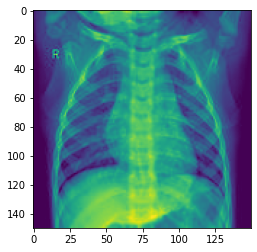

In [5]:
ld_general = Lung_Dataset()
ld_general.describe()
im = ld_general.open_img('train', 'normal', 1)
print(im.shape)
print(im)
ld_general.show_img('train', 'normal', 1)

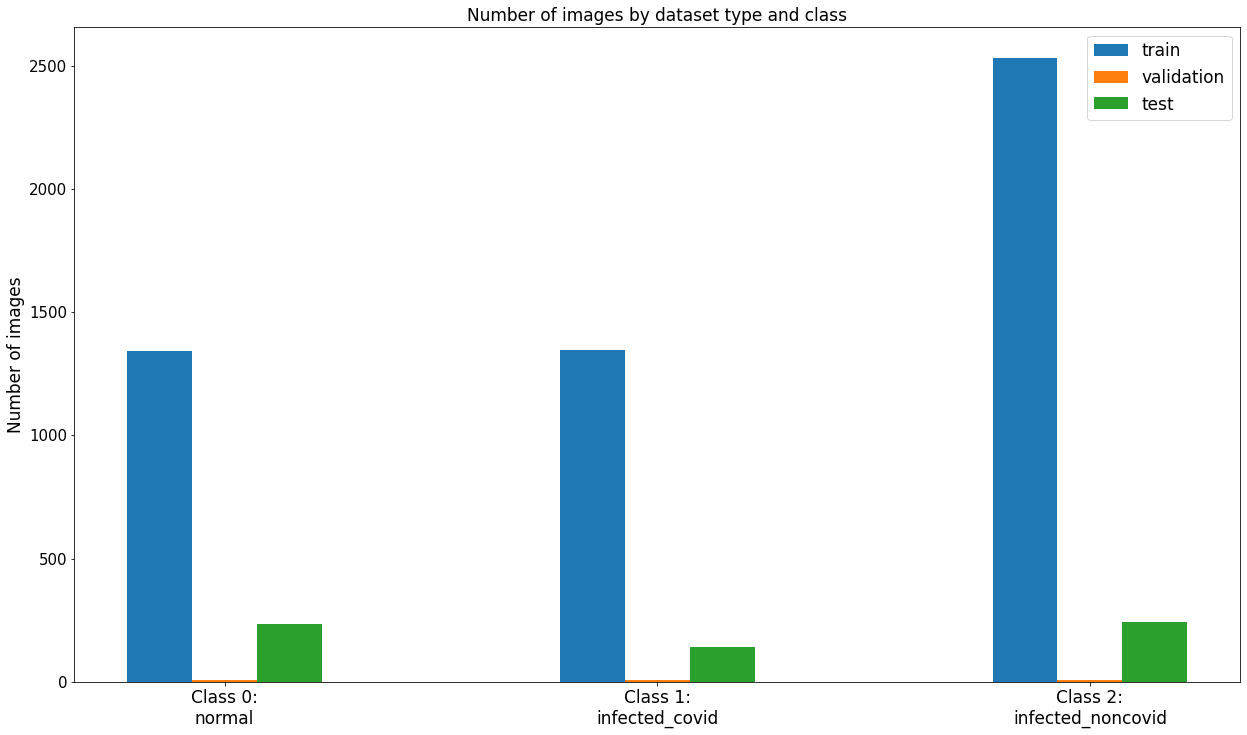

Plot has been saved as Image_Distribution.png in the submission folder.


In [6]:
ld_general.show_distribution()

2.b. Creating a train Dataset object
In practice however, one likes to define several datasets, for each subgroup (train, test, validation). This class however, will only be used to load images from the ./dataset_demo/train/ folder. It woks roughly as the previous Lung_Dataset class. In practice, we could have inherited Lung_Train_Dataset from Lung_Dataset, but we normally do not bother creating a general Dataset object like Lung_Dataset in Section 2.a.
The Lung_Train_Dataset object resembles to the Lung_Dataset as it contains restricted versions of the same attributes we had in the Lung_Dataset object.
It however contains two additional (special) methods, which need to be defined if we want to transform our Lung_Train_Dataset object into a dataloader later on.
The first method is the special length method ( len ), which should return the number of images present in the dataset. Lucky for us, it can be easily computed using the dataset_numbers attribute of our object.
The second one is the special getitem method ( getitem ), which is used to fetch an image and its label, using a single index value.
By convention here, we have decided to open the image in ./dataset_demo/train/normal/XXX.jpg, if the value in XXX is strictly lower than 36, which is the number of images in the ./dataset_demo/train/normal/ folder.
Otherwise, we open the image in ./dataset_demo/train/infected/YYY.jpg, where YYY is simply defined as YYY = XXX - 36.
Note that if the value in XXX is larger than the length of the dataset, i.e. 36 + 34 = 70, then no image will be opened and the getitem will display an error, based on the asserts we have in the open_img method.
Finally, the getitem method will return the image, along with a one-hot vector corresponding to the class of the object, i.e. [1, 0] for normal class and [0, 1] for infected class. Both returned parameters will be torch tensors.

In [27]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self, transformations_list, normalize = None):
        """
        Constructor for the Training Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected_covid, and infected_noncovid)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the original dataset
        self.og_dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530}

        # Number of images in each part of the extended dataset
        self.extended_dataset_numbers = {'train_normal': 2682,\
                                'train_infected_covid': 2690,\
                                'train_infected_noncovid': 5060}
        
        # Path to images for different parts of the original dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid/'}

        self.transform = transforms.Compose(transformations_list)   

        self.normalize = normalize                                        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "The original dataset (before data augmentation) contains a total of {} images, ".format(sum(self.og_dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.og_dataset_numbers[key])
        msg += "Data augmentation was performed to extended the training dataset. Each image was transformed once to produce a new image, "
        msg += "hence the total\nnumber of images in the extended dataset is twice the number in the original dataset, i.e. {}.\n".format(sum(self.extended_dataset_numbers.values()))
        msg += "Please note that data augmentation is only performed and transformed images are only retrieved when the dataset is loaded. "
        msg += "The augmented\ndata are not saved to files."
        print(msg)

    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.og_dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im

    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in the original dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

           
    def __len__(self):
        """
        Length special method, returns the number of images in the extended dataset.
        """
        
        # Length function
        return sum(self.extended_dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/train/normal/XXX.jpg if XXX is strictly lower than 1341 (number of images in the ./dataset/train/normal/ folder)
        - transform the image in ./dataset/train/normal/YYY.jpg if XXX is between 1341 (inclusive) and 2682 (exclusive) (twice the number of
          images in the ./dataset/train/normal/ folder), where YYY = XXX - 1341.
        - open the image in ./dataset/train/infected/covid/YYY.jpg if XXX is between 2682 (inclusive) (total number of images in class 0: normal after
          augmentation) and  4027 (exclusive) (4027 - 2682 = 1345 number of images in the ./dataset/train/infected/covid/ folder), where YYY = XXX - 2682.
        - transform the image in ./dataset/train/infected/covid/YYY.jpg if XXX is between 4027 (inclusive) and 5372 (exclusive) (total number of images in
          class 0: normal and class 1: infected_covid after augmentation), where YYY = XXX - 2682 - 1345 = XXX - 4027.
        - open the image in ./dataset/train/infected/non-covid/ folder if XXX is between 5372 (inclusive) (total number of images in class 0: normal after
          and class 1: infected_covid after augmentation) and  7902 (exclusive) (7902 - 5372 = 2530 number of images in the ./dataset/train/infected/non-covid/
          folder), where YYY = XXX - 2682 - 2690 = XXX - 5372.
        - transform the image in ./dataset/train/infected/non-covid/YYY.jpg if XXX is between 7902 (inclusive) and 10432 (exclusive) (total number of images in
          all classes after augmentation), where YYY = XXX - 5372 - 2530 = XXX - 7902.

        
        Returns the image and its label as a one hot vector, both in torch tensor format in dataset.
        """

        # Get item special method
        first_val = int(list(self.og_dataset_numbers.values())[0]) # number of images in class 0: normal = 1341
        second_val = int(list(self.og_dataset_numbers.values())[1]) # number of images in class 1: infected_covid = 1345
        third_val = int(list(self.og_dataset_numbers.values())[2]) # number of images in class 2: infected_noncovid = 2530
        if index < first_val*2: # not inclusive because image labelling starts from 0, not 1
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
            if index < first_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index-first_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)

        elif (first_val*2) <= index < (first_val + second_val)*2:
            index -= first_val*2
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])
            if index < second_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index - second_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)

        else:
            index -= (first_val + second_val)
            class_val = 'infected_noncovid'
            index -= (first_val + second_val)
            label = torch.Tensor([0, 0, 1])
            if index < third_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index - third_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)
        
        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

We can then create our Dataset object as before and display a description of the dataset.

In [28]:
transformation_list = [transforms.RandomAffine(degrees = 15, translate = (5/150, 5/150), scale=(9/8, 9/8), shear=None),\
                       transforms.GaussianBlur(kernel_size = 3, sigma=(0.1, 2.0))]
ld_train = Lung_Train_Dataset(transformation_list) # extended dataset
ld_train.describe()
print(len(ld_train)) # gives total number of images in the extended train dataset

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
The original dataset (before data augmentation) contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.
Data augmentation was performed to extended the training dataset. Each image was transformed once to produce a new image, hence the total
number of images in the extended dataset is twice the number in the original dataset, i.e. 10432.
Please note that data augmentation is only performed and transformed images are only retrieved when the dataset is loaded. The augmented
data are not saved to files.
10432


Using the getitem method (i.e. using square bracket indexing on our object) will produce a 150 by 150 torch tensor corresponding to our image, with normalize values. It also produces a one-hot vector, in torch tensor format as well.

In [ ]:
im, class_oh = ld_train[1360] # index = 1360 > 1341 so look at elif statement: 1360 - 1341 = 19 (label of image in infected_covid class)
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2196, 0.2784, 0.2980,  ..., 0.2000, 0.2078, 0.2118],
         [0.2314, 0.2667, 0.2980,  ..., 0.2039, 0.2118, 0.2118],
         [0.2471, 0.2510, 0.3020,  ..., 0.2078, 0.2196, 0.2157],
         ...,
         [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([0., 1., 0.])


2.c. Creating a test and val Dataset object
Following the same logic in Section 2.b., we can create a Lung_Test_Dataset and a Lung_Val_Dataset object. They operate in the exact same manner as the Lung_Train_Dataset object from Section 2.b., but working on a different subfolder.

In [35]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self, normalize = None):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_noncovid':242 }
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected_covid': './dataset/test/infected/covid',\
                              'test_infected_noncovid': './dataset/test/infected/non-covid'}
        
        self.normalize = normalize
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'test'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_covid, or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/test/normal/XXX.jpg if XXX is strictly lower than 234 (number of images in the ./dataset/test/normal/ folder)
        - open the image in ./dataset/test/infected/YYY.jpg if XXX is between 234 (inclusive) and 373 (exclusive) (total number of images in 
          ./dataset/test/normal and ./dataset/test/infected/covid/ folders), where YYY is defined as YYY = XXX - 234.
        - otherwise, open the image in ./dataset/test/infected/non-covid/ folder 

        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif first_val <= index < first_val + second_val:
            index -= first_val
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected_noncovid'
            index -= (first_val + second_val)
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()

        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

In [36]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 615 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid: 139 images.
 - test_infected_noncovid, in folder ./dataset/test/infected/non-covid: 242 images.



In [37]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self, normalize = None):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_noncovid': 8 }
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                              'val_infected_covid': './dataset/val/infected/covid',\
                              'val_infected_noncovid': './dataset/val/infected/non-covid'}
        
        self.normalize = normalize


    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/val/normal/XXX.jpg if XXX is strictly lower than 8 (number of images in the ./dataset/val/normal/ folder)
        - open the image in ./dataset/val/infected/YYY.jpg if XXX is between 8 (inclusive) and 17 (exclusive) (total number of images in 
          ./dataset/val/normal and ./dataset/val/infected/covid/ folders), where YYY is defined as YYY = XXX - 8.
        - otherwise, open the image in ./dataset/val/infected/non-covid/ folder 

        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif first_val <= index < first_val + second_val:
            index -= first_val
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected_noncovid'
            index -= (first_val + second_val)
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        
        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

In [38]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 25 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid: 9 images.
 - val_infected_noncovid, in folder ./dataset/val/infected/non-covid: 8 images.



3. Creating a Dataloader object
The final step is to create Dataloaders, based on our previous Dataset objects. These Dataloaders will later be used for training, testing and evaluating our models in PyTorch.
The dataloaders can be simply created by using the DataLoader object from the torch.utils.data library, and by simply passing it our Dataset object. Additional parameters such as the batch_size (set to 4 for demo here) can be specified. Another interesting parameter is the shuffle = True one, which will randomly shuffle the order in which the images are selected in the Dataset.
Additional parameters for the DataLoader can be specified (see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for details), but it will not be necessary for this small project.

In [29]:
# NORMALISATION
def get_mean(data_loader, num_of_pixels):
    total_sum = 0
    for batch in tqdm(data_loader):
        total_sum += batch[0].sum()
    mean = total_sum/num_of_pixels
    return mean


def get_standard_deviation(data_loader, num_of_pixels, mean):
    sum_of_squared_error = 0
    for batch in tqdm(data_loader):
        sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
    std = torch.sqrt(sum_of_squared_error/num_of_pixels)
    return std

In [39]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 4

# Dataloader from train dataset
train_loader = DataLoader(ld_train, batch_size = bs_val, num_workers = 1, shuffle = True)

num_of_pixels = len(ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
train_mean = get_mean(train_loader, num_of_pixels)
train_std = get_standard_deviation(train_loader, num_of_pixels, train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(train_mean, train_std))




The mean of the extended training dataset before normalisation is 0.4999254047870636.
The standard deviation of the extended training dataset before normalisation is 0.2233985960483551.


In [40]:
# Instantiating a new training dataset to be normalized before training
ld_train_normalized = Lung_Train_Dataset(transformation_list, (train_mean, train_std))

# Dataloader from normalized train dataset 
normalized_train_loader = DataLoader(ld_train_normalized, batch_size = bs_val, num_workers = 1, shuffle = True)
norm_train_mean = get_mean(normalized_train_loader, num_of_pixels)
norm_train_std = get_standard_deviation(normalized_train_loader, num_of_pixels, norm_train_mean)
print("The mean of the extended training dataset after normalisation is {}.\nThe standard deviation of the extended training dataset after normalisation is {}.".format(norm_train_mean, norm_train_std))



The mean of the extended training dataset after normalisation is 0.0002814550243783742.
The standard deviation of the extended training dataset after normalisation is 0.9999248385429382.


In [48]:
# Instantiating a new test dataset to be normalized before testing
ld_test_normalized = Lung_Test_Dataset((train_mean, train_std))

# Dataloader from normalized test dataset 
normalized_test_loader = DataLoader(ld_test_normalized, batch_size = bs_val, num_workers = 1, shuffle = True)
norm_test_mean = get_mean(normalized_test_loader, num_of_pixels)
norm_test_std = get_standard_deviation(normalized_test_loader, num_of_pixels, norm_test_mean)
print("The mean of the test dataset after normalisation is {}.\nThe standard deviation of the test dataset after normalisation is {}.".format(norm_test_mean, norm_test_std))


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8511572d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8511572d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



The mean of the test dataset after normalisation is -0.006779673974961042.
The standard deviation of the test dataset after normalisation is 0.25754380226135254.


In [49]:
# Instantiating a new validation dataset to be normalized before testing
ld_val_normalized = Lung_Val_Dataset((train_mean, train_std))

# Dataloader from validation test dataset 
normalized_val_loader = DataLoader(ld_val_normalized, batch_size = bs_val, num_workers = 1, shuffle = True)
norm_val_mean = get_mean(normalized_val_loader, num_of_pixels)
norm_val_std = get_standard_deviation(normalized_val_loader, num_of_pixels, norm_val_mean)
print("The mean of the validation dataset after normalisation is {}.\nThe standard deviation of the validation dataset after normalisation is {}.".format(norm_val_mean, norm_val_std))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8511572d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8511572d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



The mean of the validation dataset after normalisation is -1.909440106828697e-05.
The standard deviation of the validation dataset after normalisation is 0.05613541975617409.


During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.
Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.
We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [ ]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

4. Using our dataloader for training a model
We can then use our custom dataloader for training a model. If we decide to create a model as a subclass of the nn.Module of PyTorch, and later write a train function, as in this Notebook shown in class (https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8), then our train_loader object defined in Section 3., can be directly fed to our train function in place of the train_loader.
We could for instance, define a simple (probably too simple!) model below.


In [ ]:
# A simple mode
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 8 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(87616, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output


In [ ]:
# Create model
model = Net()


Later on, we will probably have to write a train function, which will implement a mini-batch loop, which resembles the one below. It will simply iterate on the DataLoader we have defined earlier.

In [ ]:
# Try model on one mini-batch
for batch_idx, (images_data, target_labels) in enumerate(train_loader):
    predicted_labels = model(images_data)
    print(predicted_labels)
    print(target_labels)
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the mini-batch for loop"

In [4]:
# DEPRECATED
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid'}
                                                   
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)


    def transform_img(self, transforms_list, random_seed = 1):
        """
        Image transformation function.
        Transforms images with specified list of transformations
        """

        # Asserts that list of transformations must be passed into the method
        err_msg = "Error - transforms_list argument cannot be an empty list."
        assert len(transforms_list) != 0, err_msg

        # Data augmentation
        torch.manual_seed(random_seed)
        transformed_normal = []
        transformed_infected_covid = []
        transformed_infected_noncovid = []
        for i in tqdm(range(len(self))):
            img, one_hot_vector = self[i]
            transformations = transforms.Compose(transforms_list) # chain of image transformations
            transformed_img = transformations(img) # returns copy of image in Tensor form, does not change self/original image
            if one_hot_vector[0] == 1:
                transformed_normal.append(transformed_img)
            elif one_hot_vector[1] == 1:
                transformed_infected_covid.append(transformed_img)
            elif one_hot_vector[2] == 1:
                transformed_infected_noncovid.append(transformed_img)
        # transformed_normal = Torch.FloatTensor(transformed_normal)
        # transformed_infected_covid = Torch.FloatTensor(transformed_infected_covid)
        # transformed_infected_noncovid. Torch.FloatTensor(transformed_infected_noncovid)
        print(len(transformed_normal), len(transformed_infected_covid), len(transformed_infected_noncovid))
        return transformed_normal, transformed_infected_covid, transformed_infected_noncovid

    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im

    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

           
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/train/normal/XXX.jpg if XXX is strictly lower than 1341 (number of images in the ./dataset/train/normal/ folder)
        - open the image in ./dataset/train/infected/YYY.jpg if XXX is between 1341 (inclusive) and 2686 (exclusive) (total number of images in 
          ./dataset/train/normal and ./dataset/train/infected/covid/ folders), where YYY is defined as YYY = XXX - 1341.
        - otherwise, open the image in ./dataset/train/infected/non-covid/ folder 

        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0]) # number of images in class 0: normal
        second_val = int(list(self.dataset_numbers.values())[1]) # number of images in class 1: infected_covid
        if index < first_val: # not inclusive because image labelling starts from 0, not 1
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif first_val <= index < first_val + second_val:
            index -= first_val
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected_noncovid'
            index -= (first_val + second_val)
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(im).float()
        return im, label